In [93]:
# library and module imports for data retrieval and munging
import sys
import warnings
sys.path.append("../src/pipeline")
from utils import query_utils as query
from utils import gait_features_utils as gproc
import synapseclient as sc
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# some scikit learn library imports for modelling
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import (train_test_split, learning_curve, GridSearchCV, cross_val_score, validation_curve)
from sklearn.impute import SimpleImputer
import sklearn.metrics as metrics
from sklearn.metrics import (classification_report, confusion_matrix, roc_curve, auc, roc_auc_score)
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.externals import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.feature_selection import RFECV, SelectKBest, chi2, SelectFromModel, RFE
from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import IterativeImputer

# magic commands
%matplotlib inline
%load_ext autoreload
%autoreload 2

# extra commands
sns.set_style("darkgrid")
sns.set_context("paper")
warnings.simplefilter("ignore")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Retrieve Data

#### Global Variables

In [3]:
WALKING_GROUPED_FEATURES = "syn21626482"
MATCHED_DEMOGRAPHICS = "syn21614563"
syn = sc.login()

Welcome, aryton tediarjo!



INFO:synapseclient_default:Welcome, aryton tediarjo!



### Helper Functions

#### a. Model Optimization

In [ ]:
# helper functions
def logreg_fit(X_train, y_train):
    pipe = Pipeline(steps=[
        ("feature_selection", SelectFromModel(RandomForestClassifier(n_estimators = 1000,
                                                                   random_state  = 100))),
        ('scaler', StandardScaler()),
        ('classifier', LogisticRegression(random_state = 100))
        ])
    param = [{'feature_selection__threshold' : ["1.2*mean", "mean"], 
                'classifier__penalty': ['l2']}, 
             {'feature_selection__threshold' : ["1.2*mean", "mean"], 
                'classifier__penalty': ['l1']}]
    CV = GridSearchCV(estimator = pipe, param_grid = param , 
                      scoring= "roc_auc", n_jobs = -1, 
                      cv = 10, verbose = True, refit = True)
    CV.fit(X_train, y_train)
    return CV

def xgb_fit(X_train, y_train):
    pipe = Pipeline(steps=[
        ("feature_selection", SelectFromModel(RandomForestClassifier(n_estimators = 1000,
                                                            random_state  = 100))),
        ('classifier', XGBClassifier(seed = 100))
        ])
    param = {
        'feature_selection__threshold' : ["1.1*mean", "mean"], 
        "classifier__learning_rate" : [0.01, 0.05, 0.1],
        "classifier__n_estimators"  : [1000, 2000],
        'classifier__max_depth':[3,6,10]
    }
    CV = GridSearchCV(estimator = pipe, param_grid = param, 
                      scoring= "roc_auc", n_jobs = -1, 
                      cv = 10, verbose = True, refit = True)
    CV.fit(X_train, y_train)
    return CV
    

def gradientboost_fit(X_train, y_train):
    pipe = Pipeline(steps=[
        ("feature_selection", SelectFromModel(estimator = RandomForestClassifier(n_estimators = 1000,
                                                                              random_state  = 100))),
        ('classifier', GradientBoostingClassifier(random_state = 100))
        ])
    param = {
        'feature_selection__threshold' : ["1.1*mean", "mean"],
        'classifier__max_depth':[3,6,10],
        'classifier__learning_rate': [0.01, 0.05, 0.1],
        "classifier__n_estimators"  : [1000, 2000]
    }
    CV = GridSearchCV(estimator = pipe, param_grid = param , 
                      scoring= "roc_auc", n_jobs = -1, 
                      cv = 10, verbose = True, refit = True)
    CV.fit(X_train, y_train)
    return CV


def randomforest_fit(X_train, y_train):
    pipe = Pipeline(steps=[
        ("feature_selection", SelectFromModel(estimator = RandomForestClassifier(n_estimators = 1000,
                                                                              random_state = 100))),
        ('classifier', RandomForestClassifier(random_state = 100))
    ])
    param = {
        'feature_selection__threshold' : ["1.1*mean", "mean"], 
        'classifier__n_estimators'  : [1000, 2000],
        'classifier__min_samples_split':[2,3]
    }
    CV = GridSearchCV(estimator = pipe, param_grid = param, 
                      scoring= "roc_auc", n_jobs = -1, cv = 10, 
                      verbose = True, refit = True)
    CV.fit(X_train, y_train)
    return CV

#### b. Model Results & Visualization Function

In [123]:
def get_results_dataframe(X_test, y_test, *models):
    data_dict = {}
    data_dict["model"] = []
    data_dict["parameter"] = []
    data_dict["roc-auc-cv"] = []
    data_dict["roc-auc-test"] = []
    data_dict["log-loss-test"] = []
    data_dict["f1-score-test"] = []
    for model in models:
        try:
            data_dict["model"].append(type(model.best_estimator_["classifier"]).__name__)
            data_dict["parameter"].append(model.best_params_)
            data_dict["roc-auc-cv"].append(model.best_score_)
        except:
            data_dict["model"].append(type(model).__name__)
            data_dict["parameter"].append(np.NaN)
            data_dict["roc-auc-cv"].append(np.NaN)
        y_true, y_pred = y_test, model.predict(X_test)
        data_dict["roc-auc-test"].append(metrics.roc_auc_score(y_true, y_pred))
        data_dict["log-loss-test"].append(metrics.log_loss(y_true, y_pred))
        data_dict["f1-score-test"].append(metrics.f1_score(y_true, y_pred))
    data = pd.DataFrame(data_dict)
    return data


def visualize_feature_importances(X_train, *models):
    
    for model in models:
        try:
            features = model.best_estimator_["classifier"].feature_importances_
        except:
            features = model.best_estimator_["classifier"].coef_[0]

        series = np.abs(pd.Series(data = features, 
                            index = X_train.columns[model.best_estimator_["feature_selection"].get_support()]))\
                            .sort_values(ascending = True).tail(20)
        plt.figure(figsize = (8,5))
        plt.title("Feature Importances based base on %s"%type(model.best_estimator_["classifier"]).__name__)
        series.plot(kind = "barh")
        plt.show()
        

def plot_roc_auc_curve(X_test, y_test, *models):
    plt.figure(figsize = (10,10))
    for model in models:
        model_name = type(model.best_estimator_["classifier"]).__name__
        fpr = dict()
        tpr = dict()
        roc_auc = dict()

        y_pred = model.predict(X_test_impute)
        for i in range(2):
            fpr[i], tpr[i], _ = roc_curve(y_test, y_pred)
            roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[1], tpr[1], label='%s ROC curve (area = %0.2f)' % (model_name, roc_auc[1] ))
    plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label = "Random Guess (area = 0.5)")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend()
    plt.show()

#### Preliminary Cleanups

In [5]:
# get data
data = query.get_file_entity(syn, WALKING_GROUPED_FEATURES )
demographic = query.get_file_entity(syn, MATCHED_DEMOGRAPHICS)


data = data[[feat for feat in data.columns if ("filepath" not in feat) 
             and ("window" not in feat) 
             and ("steps" not in feat) 
             and (feat != "index")
             and ("AA_" not in feat)]]


# filter datasets
data = data[(data["test_type"] == "walking") & 
            (data["age"] > 0) & 
            (data["table_version"] != "MPOWER_PASSIVE") &
            (data["class"] != "MS")]

# merge inner
data = pd.merge(demographic[["healthCode"]], data, on = "healthCode", how = "inner")

data = data.set_index("healthCode")

# clean sparse feature
data = data[data.columns[data.isnull().mean() < 0.2]]

# cols of choice
metadata_cols = ["test_type", "phoneInfo", "age", "gender", "table_version", "nrecords", "class"]
feat_cols = [feat for feat in data.columns if (feat not in metadata_cols)]

### 1. Impute missing data on training using MICE Model (Iterative Imputer)

In [6]:
train = data[feat_cols]
target = data["class"].map({"PD":1, "control":0})

# split train test split
X_train, X_test, y_train, y_test = train_test_split(train, target, 
                                                    test_size = 0.25,
                                                   random_state = 100)

imputer = IterativeImputer(random_state=100, initial_strategy = "median").fit(X_train)

X_train_impute = imputer.fit_transform(X_train)
X_test_impute = imputer.fit_transform(X_test)

### 2. Model Performances

#### a. Initial Model

In [116]:
init_lr_model = LogisticRegression(random_state = 100).fit(X_train_impute, y_train)
init_rf_model = RandomForestClassifier(random_state = 100).fit(X_train_impute, y_train)
init_gb_model = GradientBoostingClassifier(random_state = 100).fit(X_train_impute, y_train)
init_xgb_model = XGBClassifier(seed = 100).fit(X_train_impute, y_train)



get_results_dataframe(X_test_impute, y_test, 
                      init_xgb_model,
                     init_lr_model,
                     init_gb_model,
                     init_xgb_model)


,model,parameter,roc-auc-cv,roc-auc-test,log-loss-test,f1-score-test
0,XGBClassifier,NaN,NaN,0.638957,12.847515,0.644330
1,LogisticRegression,NaN,NaN,0.613919,13.592282,0.611702
2,GradientBoostingClassifier,NaN,NaN,0.624266,13.219890,0.620321
3,XGBClassifier,NaN,NaN,0.638957,12.847515,0.644330


#### b. Slightly Optimized Model

In [13]:
 ## models ##
cv_lr_model = logreg_fit(X_train_impute, y_train)
cv_rf_model = randomforest_fit(X_train_impute, y_train)
cv_gb_model = gradientboost_fit(X_train_impute, y_train)
cv_xgb_model = xgb_fit(X_train_impute, y_train)

Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   36.4s finished


Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   43.5s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  2.3min finished


Fitting 10 folds for each of 36 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   42.4s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed: 14.0min finished


Fitting 10 folds for each of 36 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   37.2s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  9.1min finished


### 3. Prediction Results Dataframe

In [52]:
get_results_dataframe(X_test_impute, y_test, 
                      cv_xgb_model, 
                      cv_lr_model, 
                      cv_rf_model, 
                      cv_gb_model)

,model,parameter,roc-auc-cv,roc-auc-test,log-loss-test,f1-score-test
0,XGBClassifier,"{'classifier__learning_rate': 0.01, 'classifie...",0.660125,0.604937,13.871571,0.600536
1,LogisticRegression,"{'classifier__penalty': 'l1', 'feature_selecti...",0.673318,0.613919,13.592282,0.611702
2,RandomForestClassifier,"{'classifier__min_samples_split': 2, 'classifi...",0.671846,0.625367,13.033677,0.608939
3,GradientBoostingClassifier,"{'classifier__learning_rate': 0.01, 'classifie...",0.664775,0.640058,12.661302,0.634409


### 4. Feature Importances

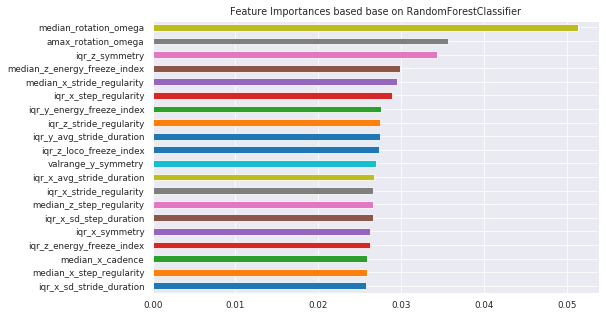

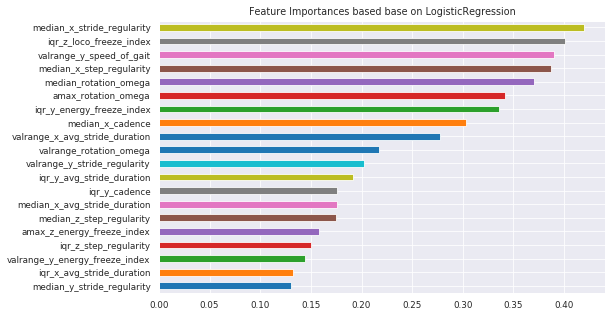

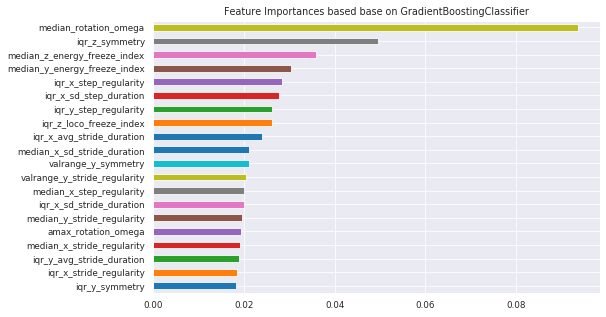

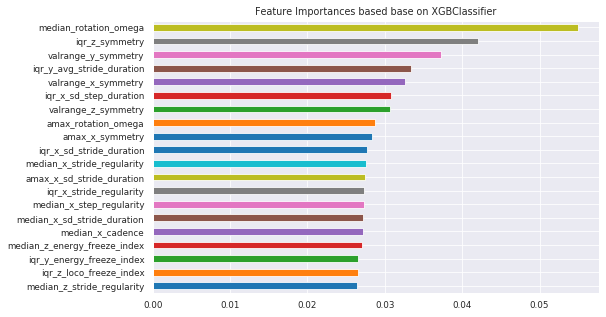

In [54]:
visualize_feature_importances(X_train, rf_walking_model, 
                              cv_lr_model, 
                              cv_gb_model, 
                              cv_xgb_model)

### 5. ROC-AUC Curve

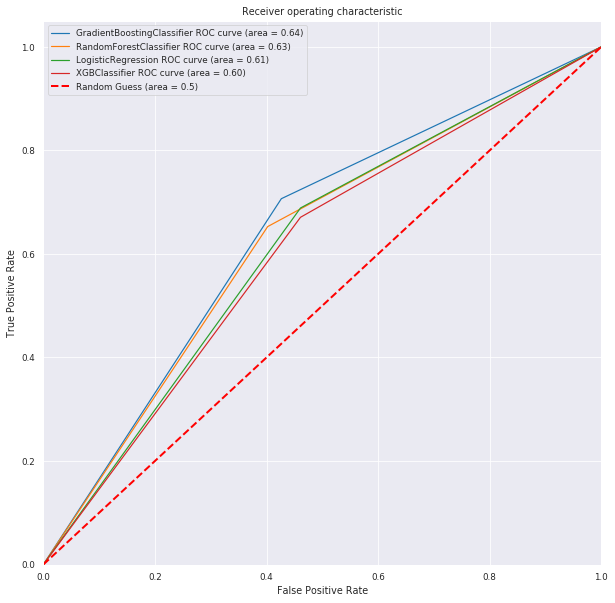

In [124]:
plot_roc_auc_curve(X_test_impute, y_test, 
                   cv_gb_model, 
                   cv_rf_walkingmodel, 
                   cv_lr_walking_model, 
                   cv_xgb_walking_model)

### 6. Learning Curve

In [129]:
def plot_learning_curves(X_train, y_train, *models):
    for model in models:
        train_sizes, train_scores, valid_scores = learning_curve(model.best_estimator_, 
                                                                X_train, y_train, 
                                                                scoring = "neg_log_loss", 
                                                                cv = 2, random_state = 100, 
                                                                train_sizes = np.linspace(0.1, 1, 10))
        pd.DataFrame(data = {"train_scores": np.mean(train_scores, axis = 1), 
                             "valid_scores": np.mean(valid_scores, axis = 1)}, index = train_sizes).plot(figsize = (8,5))
        plt.ylabel("Loss")
        plt.title("Random Forest Learning Curve")
        plt.xlabel("Training Size")
        plt.show()

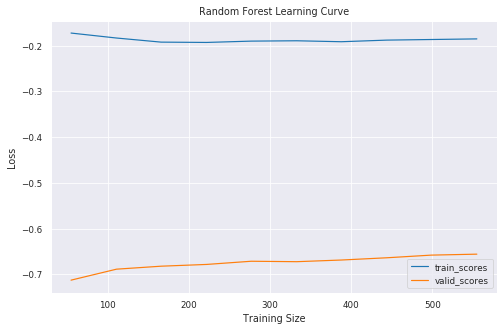

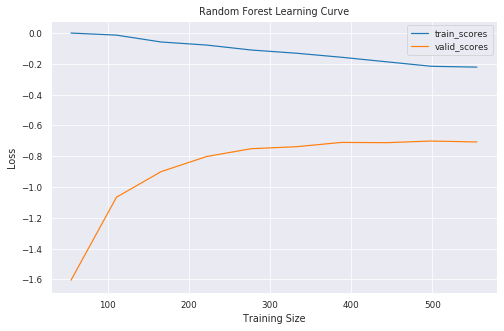

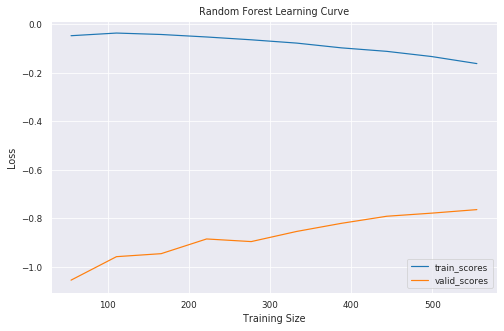

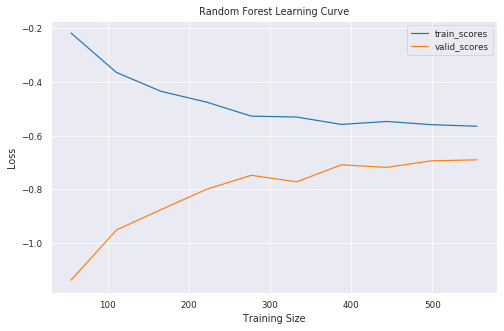

In [130]:
plot_learning_curves(X_train_impute, y_train, rf_walking_model, gb_walking_model, xgb_walking_model, lr_walking_model)